In [1]:
# Cell 1
import os
import pandas as pd
import numpy as np
from scipy import signal


In [2]:
# Cell 2
# Load the human data CSV
csv_path = "/home/rothermm/brain-diffuser/data/human_data/valence_arousal_memory_wide_format.csv"
df_human_data = pd.read_csv(csv_path)

# Define required columns
required_cols = ['SubjectID', 'Condition', 'ValenceRating', 'MemorabilityRating']
missing = set(required_cols) - set(df_human_data.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}")

# Define condition order
conditions_order = [
    'alpha0', 'mem-2', 'mem-4', 'mem+4', 'mem+2',
    'valence-2', 'valence-4', 'valence+2', 'valence+4'
]


In [3]:
# Cell 3
def detrend_preserve_mean(x):
    """Remove linear trend but preserve the mean."""
    if len(x) < 2:
        return x
    mean_val = x.mean()
    return signal.detrend(x.values) + mean_val


In [4]:
# Cell 4
df_val = (
    df_human_data[df_human_data['Condition'].isin(conditions_order)]
    .copy()
)

df_val['Condition'] = pd.Categorical(df_val['Condition'],
                                     categories=conditions_order,
                                     ordered=True)

df_val = df_val.sort_values(['SubjectID', 'Condition'])
df_val['ValenceRating_Detrended'] = (
    df_val
    .groupby('SubjectID')['ValenceRating']
    .transform(detrend_preserve_mean)
)


In [5]:
# Cell 5
df_mem = (
    df_human_data[df_human_data['Condition'].isin(conditions_order)]
    .copy()
)

df_mem['Condition'] = pd.Categorical(df_mem['Condition'],
                                     categories=conditions_order,
                                     ordered=True)

df_mem = df_mem.sort_values(['SubjectID', 'Condition'])
df_mem['MemorabilityRating_Detrended'] = (
    df_mem
    .groupby('SubjectID')['MemorabilityRating']
    .transform(detrend_preserve_mean)
)


In [6]:
# Cell 6
# Merge the two detrended columns into a single DataFrame
# Assumes both dfs are sorted and aligned (safe here since identical filter/sort logic)
df_val['MemorabilityRating_Detrended'] = df_mem['MemorabilityRating_Detrended']

# Select relevant columns for saving
human_df_detrended = df_val[[
    'SubjectID', 'Condition', 'ValenceRating_Detrended', 'MemorabilityRating_Detrended'
]]

# Rename for consistency
human_df_detrended.rename(columns={
    'ValenceRating_Detrended': 'ValenceRating',
    'MemorabilityRating_Detrended': 'MemorabilityRating'
}, inplace=True)

# Optional: Save to CSV or Pickle
output_path = "/home/rothermm/brain-diffuser/data/human_data/human_df_detrended.csv"
human_df_detrended.to_csv(output_path, index=False)
print(f"✅ Detrended data saved to: {output_path}")


✅ Detrended data saved to: /home/rothermm/brain-diffuser/data/human_data/human_df_detrended.csv


/tmp/ipykernel_814865/1539881410.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_df_detrended.rename(columns={


# Analyze the data

In [7]:
human_df_detrended.columns

Index(['SubjectID', 'Condition', 'ValenceRating', 'MemorabilityRating'], dtype='object')

In [8]:
human_df_detrended["SubjectID"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])

In [9]:
# Show full list of unique condition values as a list
print(human_df_detrended["Condition"].cat.categories.tolist())


['alpha0', 'mem-2', 'mem-4', 'mem+4', 'mem+2', 'valence-2', 'valence-4', 'valence+2', 'valence+4']


# plotting

In [10]:
# Cell 7
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)


In [11]:
# Cell 8
def plot_condition_comparison(df_original, df_detrended, rating_col, condition_order, title, ylabel):
    """
    Plots the average ratings (original vs detrended) across given condition_order.
    
    Parameters:
        df_original (DataFrame): Original wide-format data.
        df_detrended (DataFrame): Detrended version.
        rating_col (str): Column to compare, e.g. 'MemorabilityRating' or 'ValenceRating'.
        condition_order (list): Ordered list of conditions for the x-axis.
        title (str): Title of the plot.
        ylabel (str): Y-axis label.
    """
    # Compute group means
    mean_orig = (
        df_original[df_original["Condition"].isin(condition_order)]
        .groupby("Condition")[rating_col]
        .mean()
        .reindex(condition_order)
    )
    mean_det = (
        df_detrended[df_detrended["Condition"].isin(condition_order)]
        .groupby("Condition")[rating_col]
        .mean()
        .reindex(condition_order)
    )

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(condition_order, mean_orig, marker='o', label="Original")
    plt.plot(condition_order, mean_det, marker='x', linestyle='--', label="Detrended")

    plt.title(title)
    plt.xlabel("Condition")
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', linewidth=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_814865/2365888466.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Condition")[rating_col]
/tmp/ipykernel_814865/2365888466.py:39: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/rothermm/.conda/envs/mediaeval/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


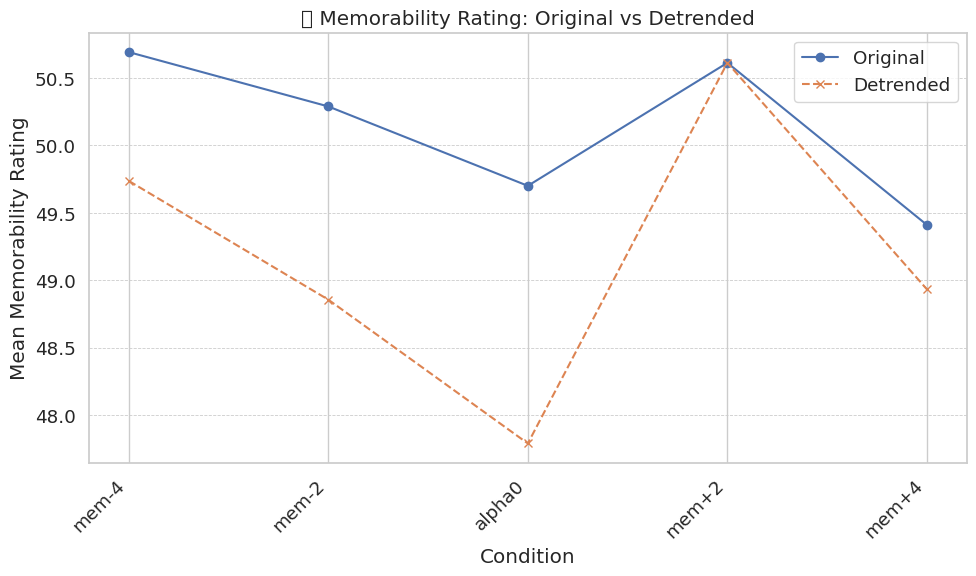

In [12]:
# Cell 9
mem_conditions = ['mem-4', 'mem-2', 'alpha0', 'mem+2', 'mem+4']

plot_condition_comparison(
    df_original=df_human_data,
    df_detrended=human_df_detrended,
    rating_col='MemorabilityRating',
    condition_order=mem_conditions,
    title="📈 Memorability Rating: Original vs Detrended",
    ylabel="Mean Memorability Rating"
)


/tmp/ipykernel_814865/2365888466.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Condition")[rating_col]
/tmp/ipykernel_814865/2365888466.py:39: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/rothermm/.conda/envs/mediaeval/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


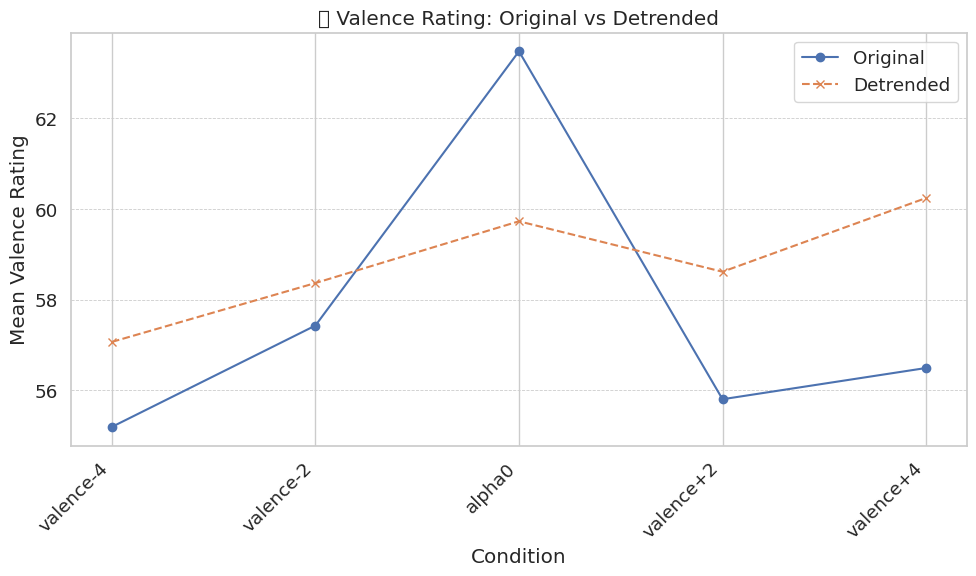

In [13]:
# Cell 10
val_conditions = ['valence-4', 'valence-2', 'alpha0', 'valence+2', 'valence+4']

plot_condition_comparison(
    df_original=df_human_data,
    df_detrended=human_df_detrended,
    rating_col='ValenceRating',
    condition_order=val_conditions,
    title="📈 Valence Rating: Original vs Detrended",
    ylabel="Mean Valence Rating"
)


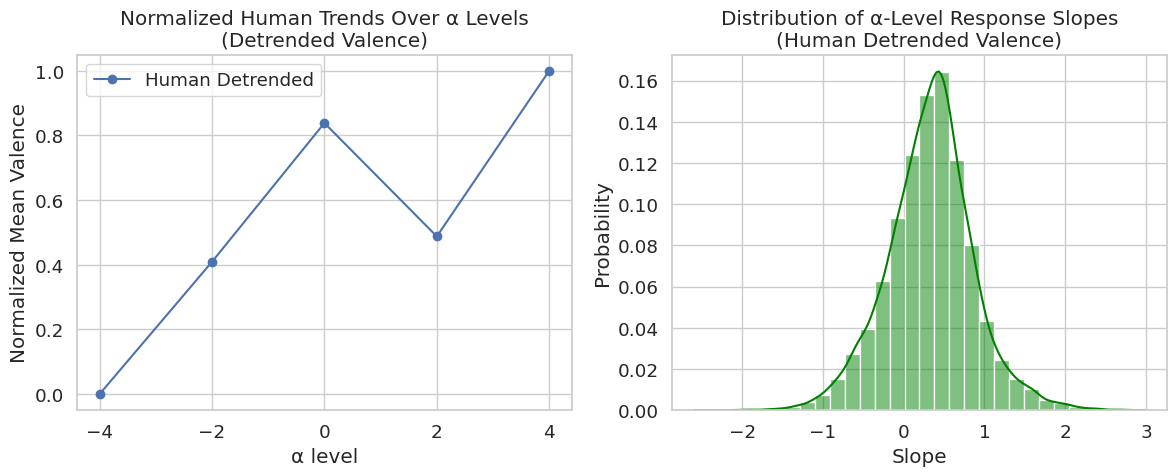

In [17]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from sklearn.utils import resample

# Cell 2: Load detrended data
data_path = "/home/rothermm/brain-diffuser/data/human_data/human_df_detrended.csv"
df = pd.read_csv(data_path)

# Keep only valence conditions
val_conditions = ['valence-4', 'valence-2', 'alpha0', 'valence+2', 'valence+4']
df = df[df['Condition'].isin(val_conditions)].copy()

# Map alpha levels for x-axis
alpha_map = {'valence-4': -4, 'valence-2': -2, 'alpha0': 0, 'valence+2': 2, 'valence+4': 4}
df['alpha_level'] = df['Condition'].map(alpha_map)

# Cell 3: Normalize mean valence ratings
mean_ratings = (
    df.groupby(['Condition', 'alpha_level'])['ValenceRating']
    .mean()
    .reset_index()
    .sort_values(by='alpha_level')  # ✅ Now alpha_level exists
)

# Min-max normalize
min_val, max_val = mean_ratings['ValenceRating'].min(), mean_ratings['ValenceRating'].max()
mean_ratings['NormalizedValence'] = (mean_ratings['ValenceRating'] - min_val) / (max_val - min_val)


# Cell 4: Bootstrap slopes
n_bootstrap = 1000
slopes = []

for i in range(n_bootstrap):
    boot_df = resample(df, replace=True, n_samples=len(df))
    subj_slopes = []
    for subj, group in boot_df.groupby('SubjectID'):
        if group['alpha_level'].nunique() >= 2:  # Need at least 2 points to fit slope
            slope, _, _, _, _ = linregress(group['alpha_level'], group['ValenceRating'])
            subj_slopes.append(slope)
    slopes.extend(subj_slopes)

# Cell 5: Plotting
sns.set(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel A: Normalized mean valence ratings
axes[0].plot(
    mean_ratings['alpha_level'],
    mean_ratings['NormalizedValence'],
    marker='o',
    linestyle='-',
    label='Human Detrended'
)
axes[0].set_title("Normalized Human Trends Over α Levels\n(Detrended Valence)")
axes[0].set_xlabel("α level")
axes[0].set_ylabel("Normalized Mean Valence")
axes[0].set_xticks([-4, -2, 0, 2, 4])
axes[0].legend()

# Panel B: Bootstrap slope distribution
sns.histplot(slopes, kde=True, color='green', bins=30, ax=axes[1], stat="probability")
axes[1].set_title("Distribution of α-Level Response Slopes\n(Human Detrended Valence)")
axes[1].set_xlabel("Slope")
axes[1].set_ylabel("Probability")

plt.tight_layout()
plt.show()


In [15]:
df.head()

,SubjectID,Condition,ValenceRating,MemorabilityRating,alpha_level
0,1,alpha0,56.750567,61.706183,0
1,1,alpha0,67.020776,64.248593,0
2,1,alpha0,49.378485,54.663503,0
3,1,alpha0,47.479945,13.150913,0
4,1,alpha0,51.700154,55.375823,0


In [16]:
df.columns

Index(['SubjectID', 'Condition', 'ValenceRating', 'MemorabilityRating',
       'alpha_level'],
      dtype='object')